In [1]:
# ==============================================================================
# PROYECTO FINAL: TOPOLOGÍA COMPUTACIONAL
# ==============================================================================
# Autoras: María Sáez Díaz y Jessica Xianping Ren
# Descripción: Implementación de complejos simpliciales, homología, 
# filtraciones (Rips/Alpha) y persistencia topológica.
# ==============================================================================

import numpy as np
import matplotlib.pyplot as plt
import math
from itertools import combinations
from scipy.spatial import Delaunay, Voronoi, voronoi_plot_2d  # Rips/Alpha/Voronoi

# Configuración de gráficos
plt.style.use('seaborn-v0_8-whitegrid')

print("1. Librerías cargadas correctamente.")

def smith_normal_form_z2(matrix):
    """
    Calcula el rango de una matriz sobre el cuerpo finito Z2 

    Esta función realiza una reducción por filas y columnas (eliminación gaussiana)
    para llevar la matriz a una forma diagonal (Forma Normal de Smith sobre un cuerpo).
    El número de elementos no nulos en la diagonal final corresponde al rango de la matriz.

    Este cálculo es fundamental para obtener los números de Betti:
    b_p = n_p - rank(d_p) - rank(d_{p+1})

    Parámetros:
    -----------
    matrix : np.ndarray
        Matriz de entrada (se espera que contenga 0s y 1s).
        
    Retorna:
    --------
    int
        El rango de la matriz sobre Z2.
    """

    # Si la matriz está vacía, el rango es 0
    if matrix.size == 0:
        return 0
    
    # Trabajamos sobre una copia para no alterar la matriz original
    # Aseguramos que sea de tipo entero para las operaciones módulo 2
    M = matrix.copy().astype(int)
    rows, cols = M.shape
    pivot_row = 0
    pivot_col = 0
    rank = 0

    # Algoritmo de eliminación (Reducción Gaussiana)
    while pivot_row < rows and pivot_col < cols:
        # Buscamos un pivote en la columna actual, desde la fila actual hacia abajo
        pivot_indices = np.where(M[pivot_row:, pivot_col] == 1)[0]
        if pivot_indices.size == 0:
            # No hay pivote en esta columna, pasamos a la siguiente
            pivot_col += 1
            continue

        # Si encontramos un pivote, lo movemos a la posición (pivot_row, pivot_col)
        # pivot_indices[0] es relativo al slice, sumamos pivot_row para el índice absoluto
        current_pivot_row = pivot_indices[0] + pivot_row
        if current_pivot_row != pivot_row:
            # Intercambio de filas
            M[[pivot_row, current_pivot_row]] = M[[current_pivot_row, pivot_row]]
            
        # Eliminación por filas: hacemos ceros debajo del pivote
        for i in range(pivot_row + 1, rows):
            if M[i, pivot_col] == 1:
                M[i, :] = (M[i, :] + M[pivot_row, :]) % 2

        # Eliminación por columnas: hacemos ceros a la derecha del pivote
        for j in range(pivot_col + 1, cols):
            if M[pivot_row, j] == 1:
                M[:, j] = (M[:, j] + M[:, pivot_col]) % 2

        # Avanzamos al siguiente elemento de la diagonal
        pivot_row += 1
        pivot_col += 1
        rank += 1
        
    return rank


1. Librerías cargadas correctamente.


In [3]:
class SimplicialComplex:
    """
    Clase principal para la representación y análisis de Complejos Simpliciales.

    Permite construir complejos manualmente o mediante filtraciones (Rips/Alpha),
    calcular propiedades topológicas básicas (Euler, Componentes Conexas, Estrella/Link)
    y realizar análisis de homología persistente (Números de Betti).

    Atributos:
    ----------
    _simplices : set
        Conjunto de todos los símplices (frozensets) que forman el complejo.
        Se usa un set para búsquedas O(1) y evitar duplicados.
    _simplex_values : dict
        Diccionario {simplex: valor_filtración} que almacena cuándo aparece cada símplice.
    """
    
    def __init__(self, simplices=None):
        """
        Inicializa un complejo simplicial.

        Parámetros:
        -----------
        simplices : list, opcional
            Lista de símplices para inicializar el complejo. 
            Puede ser una lista de tuplas [(0,1), (1,2)] o con valores [((0,1), 0.5)].
            Si se proporciona, se insertan automáticamente manteniendo la clausura.
        """
        self._simplices = set()
        self._simplex_values = {} # Diccionario para almacenar el valor de filtración. {simplex: float_value}

        if simplices:
            self.insert(simplices)

    # ==========================================================================
    # GESTIÓN DE DATOS Y FILTRACIÓN
    # ==========================================================================

    def add_simplex(self, simplex, value=0.0):
        """
        Añade un único símplice y asegura la propiedad de clausura (añade todas sus caras).

        Si el símplice ya existe, actualiza su valor de filtración si el nuevo valor es menor.

        Parámetros:
        -----------
        simplex : iterable
            Vértices del símplice (ej: [0, 1, 2]).
        value : float, opcional
            Valor de filtración (tiempo de nacimiento). Por defecto 0.0.
        """
        
        # Convertimos a frozenset para que sea hashable y pueda guardarse en un set
        simplex_set = frozenset(simplex)
        if not simplex_set: return

        # Para generar las caras correctamente, necesitamos una secuencia ordenada
        simplex_tuple = tuple(sorted(simplex))
        n = len(simplex_tuple)

        # Generamos todas las caras de dimensión 1 hasta n (el propio símplice)
        for r in range(1, n + 1):
            for face in combinations(simplex_tuple, r):
                face_frozen = frozenset(face)
                self._simplices.add(face_frozen)
                
                # Actualizamos el valor de filtración (nos quedamos con el nacimiento más temprano)
                if face_frozen not in self._simplex_values or value < self._simplex_values[face_frozen]:
                    self._simplex_values[face_frozen] = float(value)

    def insert(self, simplices_input, value=0.0):
        """
        Interfaz flexible para insertar múltiples símplices a la vez.

        Admite dos formatos en la lista de entrada:
        1. Solo geometría: [(0, 1), (1, 2)] -> Se usa el valor 'value' por defecto.
        2. Geometría y valor: [((0, 1), 0.5), ((1, 2), 0.8)] -> Se usa el valor específico.

        Parámetros:
        -----------
        simplices_input : list
            Lista de símplices.
        value : float, opcional
            Valor por defecto si no se especifica en la lista.
        """
        
        for item in simplices_input:
            # Detecta si es formato ((0,1), 0.5) o solo (0,1)
            # Verificamos len(item)==2 y que el primer elemento sea un iterable (símplice)
            if isinstance(item, tuple) and len(item) == 2 and isinstance(item[0], (tuple, list, np.ndarray, set)):
                self.add_simplex(item[0], item[1])
            else:
                self.add_simplex(item, value)

    # --- MÉTODOS CORREGIDOS (FUERA DE INSERT) ---

    def filtration(self, t):
        """
        Genera un subcomplejo filtrado K_t que contiene solo los símplices 
        cuyo valor de nacimiento es <= t.

        Parámetros:
        -----------
        t : float
            Umbral de filtración.

        Retorna:
        --------
        SimplicialComplex
            Un nuevo objeto SimplicialComplex con los símplices filtrados.
        """

        # Recuperamos los datos originales (tuple) para poder crear la nueva instancia
        valid_data = [(tuple(s), v) for s, v in self._simplex_values.items() if v <= t]
        return SimplicialComplex(valid_data)

    def threshold(self):
        """
        Obtiene todos los valores críticos de la filtración ordenados.

        Retorna:
        --------
        list
            Lista ordenada de floats con los tiempos de nacimiento únicos.
        """
        
        return sorted(list(set(self._simplex_values.values())))

    # ==========================================================================
    # PROPIEDADES TOPOLÓGICAS BÁSICAS
    # ==========================================================================

    @property
    def dimension(self):
        """La dimensión del complejo (la dimensión máxima de sus símplices)."""
        if not self._simplices: return -1
        # Restamos 1 porque len([v0, v1]) = 2, pero es un 1-símplice (arista)
        return max(len(f) for f in self._simplices) - 1

    def n_faces(self, n):
        """
        Devuelve todas las caras de una dimensión específica n.

        Parámetros:
        -----------
        n : int
            Dimensión deseada (0=vértices, 1=aristas, 2=triángulos...).

        Retorna:
        --------
        list
            Lista de tuplas ordenadas representando los n-símplices.
        """
        
        faces = [f for f in self._simplices if len(f) - 1 == n]
        return sorted([tuple(sorted(f)) for f in faces])

    @property
    def face_set(self):
        """
        Devuelve todas las caras del complejo, ordenadas primero por dimensión 
        y luego lexicográficamente. Útil para visualización y depuración.
        """
        return sorted([tuple(sorted(f)) for f in self._simplices], key=lambda x: (len(x), x))

    @property
    def euler_characteristic(self):
        """
        Calcula la Característica de Euler (χ).
        Fórmula: χ = Σ (-1)^k * (número de k-símplices)
        """
        return sum((-1)**(len(f)-1) for f in self._simplices)

    def star(self, simplex):
        """
        Calcula la Estrella (Star) de un símplice σ.
        Star(σ) = {τ ∈ K | σ ⊆ τ}
        Conjunto de todos los símplices que contienen a σ.
        """
        target = frozenset(simplex)
        # Devolvemos tuplas ordenadas para facilitar lectura
        return [tuple(sorted(s)) for s in self._simplices if target.issubset(s)]

    def link(self, simplex):
        """
        Calcula el Link (Enlace) de un símplice σ.
        Lk(σ) = {τ ∈ Star(σ) | τ ∩ σ = ∅}
        Es la "frontera" de la estrella.

        Retorna:
        --------
        SimplicialComplex
            Un nuevo complejo simplicial que representa el Link.
        """
        target = frozenset(simplex)
        link_faces = []
        for s in self._simplices:
            if target.issubset(s):
                # Obtenemos la cara que completa a 'target' dentro de 's'
                diff = s - target
                if diff:
                    link_faces.append(tuple(sorted(diff)))
        # Devolvemos un objeto SimplicialComplex
        return SimplicialComplex(link_faces)

    def connected_components(self):
        """
        Calcula el número de componentes conexas (Betti-0) usando Union-Find.
        Es más eficiente que calcular rangos de matrices para dimensión 0.
        """
        vertices = set(v for s in self._simplices for v in s)
        if not vertices: return 0
        
        parent = {v: v for v in vertices}

        def find(v):
            if parent[v] != v: parent[v] = find(parent[v])
            return parent[v]

        def union(u, v):
            root_u, root_v = find(u), find(v)
            if root_u != root_v: parent[root_u] = root_v

        # Unimos vértices conectados por aristas (1-símplices)
        for edge in self.n_faces(1):
            union(edge[0], edge[1])

        # El número de componentes es el número de raíces únicas
        return len({find(v) for v in vertices})

    # ==========================================================================
    # ÁLGEBRA HOMOLÓGICA (Números de Betti)
    # ==========================================================================

    def boundary_matrix(self, p):
        """
        Construye la matriz de borde ∂p (M_p) para la dimensión p.
        Mapea p-cadenas a (p-1)-cadenas.

        Parámetros:
        -----------
        p : int
            Dimensión del operador borde.

        Retorna:
        --------
        np.ndarray
            Matriz binaria (0s y 1s) donde M[i, j] = 1 si la cara i-ésima
            es frontera del símplice j-ésimo.
        """
        if p <= 0: return np.zeros((0, 0))
        
        row_faces = self.n_faces(p-1) # (p-1)-símplices (filas: destino)
        col_faces = self.n_faces(p)   # p-símplices (columnas: origen)
        
        if not col_faces: return np.zeros((0, 0))
        if not row_faces: return np.zeros((0, len(col_faces)))

        # Mapeamos cada cara (frozenset) a su índice de fila para acceso rápido
        idx_map = {frozenset(f): i for i, f in enumerate(row_faces)}
        M = np.zeros((len(row_faces), len(col_faces)), dtype=int)

        for j, sigma in enumerate(col_faces):
            sigma_set = set(sigma)
            for v in sigma: 
                # Una cara se obtiene quitando un vértice v del símplice sigma
                face = frozenset(sigma_set - {v})
                if face in idx_map:
                    M[idx_map[face], j] = 1
        return M

    def betti_numbers(self):
        """
        Calcula los Números de Betti (βp) para todas las dimensiones del complejo.
        Usa la fórmula: βp = np - rank(∂p) - rank(∂p+1)
        
        Donde:
        - np: número de p-símplices.
        - rank(∂p): rango de la matriz de borde de p a p-1.

        Retorna:
        --------
        dict
            Diccionario {dimensión: número_betti}. Ej: {0: 1, 1: 0}
        """
        dim = self.dimension
        bettis = {}
        ranks = {}

        # 1. Calcular rangos de todas las matrices borde necesarias
        # Usamos la función externa smith_normal_form_z2 para reducir la matriz
        for p in range(1, dim + 2):
            M = self.boundary_matrix(p)
            # USAMOS TU FUNCIÓN AQUÍ:
            ranks[p] = smith_normal_form_z2(M) if M.size > 0 else 0
        
        # 2. Betti 0: nº vértices - rango(M_1) (Componentes conexas)
        s0 = len(self.n_faces(0))
        bettis[0] = s0 - ranks.get(1, 0)

        # 3. Betti p > 0: s_p - rank(M_p) - rank(M_{p+1}) (Ciclos - Fronteras)
        for p in range(1, dim + 1):
            sp = len(self.n_faces(p))
            bettis[p] = sp - ranks.get(p, 0) - ranks.get(p + 1, 0)
            
        return bettis

    # ==========================================================================
    # ALGORITMO INCREMENTAL
    # ==========================================================================
    
    def incremental_algorithm(self):
        """
        Ejecuta el algoritmo incremental para calcular la evolución de los
        números de Betti conforme se añaden símplices (filtración).

        Clasifica cada símplice como:
        - Positivo (+): Crea un nuevo ciclo (aumenta Betti).
        - Negativo (-): Cierra un ciclo existente (disminuye Betti).

        Retorna:
        --------
        list
            Historial de cambios [{'val': t, 'simplex': s, 'bettis': {0:1, ...}}].
        """
        # Ordenamos todos los símplices por valor de filtración y luego por dimensión
        # Esto simula el crecimiento del complejo K_0 -> K_1 -> ... -> K_n
        ordered_simplices = sorted(
            self._simplex_values.items(), 
            key=lambda x: (x[1], len(x[0]))
        )
        
        history = []
        K_current = SimplicialComplex()
        
        print(f"{'Simplex':<20} | {'Tipo':<15} | {'Bettis'}")
        print("-" * 60)

        for simplex_set, val in ordered_simplices:
            simplex = tuple(sorted(simplex_set))
            dim = len(simplex) - 1
            
            # Calculamos Betti ANTES de insertar el nuevo símplice
            # (En una implementación optimizada esto se haría actualizando la matriz, no recalculando todo)
            betti_old = K_current.betti_numbers().get(dim, 0) if dim >=0 else 0
            if dim > 0:
                 betti_old_prev = K_current.betti_numbers().get(dim-1, 0)
            else:
                 betti_old_prev = 0

            # Insertamos el símplice en el complejo actual
            K_current.add_simplex(simplex, val)
            
            # Calculamos Betti DESPUÉS de insertar
            betti_new = K_current.betti_numbers()
            
            # Determinamos el tipo de cambio topológico
            simplex_type = ""
            if betti_new.get(dim, 0) > betti_old:
                simplex_type = "Positivo (+)" # Crea un nuevo ciclo en dimensión dim
            elif dim > 0 and betti_new.get(dim-1, 0) < betti_old_prev:
                simplex_type = "Negativo (-)" # Destruye un ciclo en dimensión dim-1 (lo rellena)
            else:
                if dim == 0: simplex_type = "Positivo (+)" # Un vértice siempre crea una componente nueva
            
            print(f"{str(simplex):<20} | {simplex_type:<15} | {betti_new}")
            history.append({'val': val, 'simplex': simplex, 'bettis': betti_new.copy()})
            
        return history
    
print("2. Clase complejo simplicial cargada")

2. Clase complejo simplicial cargada


In [4]:
print("--- Ejemplo 1 ---")

#Creamos el símplice definiendo los maximales
sc_mariposa = SimplicialComplex([(0,1,2), (2,3,4)])


print("1. Dimensión:")
print(sc_mariposa.dimension)

print("\n2. Característica de Euler (V=5, A=6, C=2 -> 5-6+2 = 1):")
print(sc_mariposa.euler_characteristic)

print("\n3. Estrella del vértice central (2):")
# Debería mostrar todas las caras que tocan el 2
print(sc_mariposa.star((2,)))

print("\n4. Link del vértice central (2):")
# Debería ser la frontera opuesta: la arista (0,1) y la arista (3,4)
print(sc_mariposa.link((2,)).face_set)

--- Ejemplo 1 ---
1. Dimensión:
2

2. Característica de Euler (V=5, A=6, C=2 -> 5-6+2 = 1):
1

3. Estrella del vértice central (2):
[(2,), (2, 3, 4), (2, 3), (1, 2), (0, 1, 2), (0, 2), (2, 4)]

4. Link del vértice central (2):
[(0,), (1,), (3,), (4,), (0, 1), (3, 4)]


In [4]:
print("\n--- EJEMPLO 2 EL OCHO (1-Esqueleto) ---")
# Definimos solo las aristas (hueco)
simplices_ocho = [
    (0,1), (1,2), (0,2), # Bucle 1
    (2,3), (3,4), (2,4)  # Bucle 2
]
sc_ocho = SimplicialComplex(simplices_ocho)

print("1. Caras (Aristas y vértices):")
# Imprimimos solo aristas para no saturar
print(sorted(sc_ocho.n_faces(1)))

print("\n2. Componentes conexas:")
print(sc_ocho.connected_components())

print("\n3. Característica de Euler (V=5, A=6 -> 5-6 = -1):")
print(sc_ocho.euler_characteristic)

print("\n4. Números de Betti (Esperado {0:1, 1:2}):")
print(sc_ocho.betti_numbers())


--- EJEMPLO 2 EL OCHO (1-Esqueleto) ---
1. Caras (Aristas y vértices):
[(0, 1), (0, 2), (1, 2), (2, 3), (2, 4), (3, 4)]

2. Componentes conexas:
1

3. Característica de Euler (V=5, A=6 -> 5-6 = -1):
-1

4. Números de Betti (Esperado {0:1, 1:2}):
{0: 1, 1: 2}


In [5]:
print("\n--- EJEMPLO 3: SISTEMA DESCONECTADO ---")
# Un tetraedro sólido y una arista lejos
sc_disjoint = SimplicialComplex([(0,1,2,3), (5,6)])

print("1. Conjunto de 3-símplices:")
print(sc_disjoint.n_faces(3))

print("\n2. Conjunto de 1-símplices (Aristas):")
# Notar que el tetraedro genera muchas aristas, y (5,6) está aparte
print(sorted(sc_disjoint.n_faces(1)))

print("\n3. Número de componentes conexas (Esperado: 2):")
print(sc_disjoint.connected_components())

print("\n4. Estrella del vértice aislado (5):")
print(sc_disjoint.star((5,)))


--- EJEMPLO 3: SISTEMA DESCONECTADO ---
1. Conjunto de 3-símplices:
[(0, 1, 2, 3)]

2. Conjunto de 1-símplices (Aristas):
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3), (5, 6)]

3. Número de componentes conexas (Esperado: 2):
2

4. Estrella del vértice aislado (5):
[(5, 6), (5,)]


In [6]:
print("--- EJEMPLO 4: PIRÁMIDE (Filtración por Etapas) ---")
sc_pyr = SimplicialComplex()

# t=1.0: Vértices (0,1,2 base, 3 cúspide)
sc_pyr.insert([((0,), 1.0), ((1,), 1.0), ((2,), 1.0), ((3,), 1.0)])

# t=2.0: Aristas de la base (Triángulo hueco)
sc_pyr.insert([((0,1), 2.0), ((1,2), 2.0), ((0,2), 2.0)])

# t=3.0: Aristas laterales (Conectan la base con la cúspide)
sc_pyr.insert([((0,3), 3.0), ((1,3), 3.0), ((2,3), 3.0)])

# t=4.0: Caras (Rellenan la superficie, dejando el interior vacío)
# Nota: No añadimos el tetraedro sólido (0,1,2,3), solo las caras externas.
sc_pyr.insert([((0,1,2), 4.0), ((0,1,3), 4.0), ((1,2,3), 4.0), ((0,2,3), 4.0)])

# Analizamos la evolución
etapas = {
    1.0: "Vértices",
    2.0: "Base Hueca",
    3.0: "Esqueleto Alambre",
    4.0: "Superficie Cerrada"
}

for t, desc in etapas.items():
    k_t = sc_pyr.filtration(t)
    print(f"\nTiempo t={t} ({desc}):")
    print(f"  Caras: {sorted(list(k_t.face_set), key=lambda x: (len(x), x))}")
    bettis = k_t.betti_numbers()
    desc_betti = ""
    if t == 1.0: desc_betti = "-> 4 componentes desconectadas"
    elif t == 2.0: desc_betti = "-> 1 ciclo (base) y el vértice 3 suelto"
    elif t == 3.0: desc_betti = "-> Estructura conectada con múltiples ciclos"
    elif t == 4.0: desc_betti = "-> ¡Nace una cavidad (void) en dim 2!"
    
    print(f"  Betti: {bettis} {desc_betti}")

print("\nOrden de Filtración:")
print(sorted(sc_pyr._simplex_values.items(), key=lambda x: (x[1], len(x[0]), x[0])))

--- EJEMPLO 4: PIRÁMIDE (Filtración por Etapas) ---

Tiempo t=1.0 (Vértices):
  Caras: [(0,), (1,), (2,), (3,)]
  Betti: {0: 4} -> 4 componentes desconectadas

Tiempo t=2.0 (Base Hueca):
  Caras: [(0,), (1,), (2,), (3,), (0, 1), (0, 2), (1, 2)]
  Betti: {0: 2, 1: 1} -> 1 ciclo (base) y el vértice 3 suelto

Tiempo t=3.0 (Esqueleto Alambre):
  Caras: [(0,), (1,), (2,), (3,), (0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
  Betti: {0: 1, 1: 3} -> Estructura conectada con múltiples ciclos

Tiempo t=4.0 (Superficie Cerrada):
  Caras: [(0,), (1,), (2,), (3,), (0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3), (0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3)]
  Betti: {0: 1, 1: 0, 2: 1} -> ¡Nace una cavidad (void) en dim 2!

Orden de Filtración:
[(frozenset({0}), 1.0), (frozenset({1}), 1.0), (frozenset({2}), 1.0), (frozenset({3}), 1.0), (frozenset({0, 1}), 2.0), (frozenset({1, 2}), 2.0), (frozenset({0, 2}), 2.0), (frozenset({0, 3}), 3.0), (frozenset({1, 3}), 3.0), (frozenset({2, 3}), 3.0), (frozenset

In [7]:
print("--- PDF EJEMPLO 1 y 2: TETRAEDRO ---")
# Definimos el 3-símplice (0,1,2,3)
sc_ex1 = SimplicialComplex([(0,1,2,3)])

print(f"Dimensión: {sc_ex1.dimension}")
print(f"Característica de Euler: {sc_ex1.euler_characteristic}")

print("\nEstrella de la arista (0,1):")
# Ordenamos para facilitar lectura
print(sorted(sc_ex1.star((0,1)), key=lambda x: (len(x), x)))

print("\nLink de la arista (0,1):")
print(sc_ex1.link((0,1)).face_set)

print(f"\nNúmero de componentes conexas: {sc_ex1.connected_components()}")

--- PDF EJEMPLO 1 y 2: TETRAEDRO ---
Dimensión: 3
Característica de Euler: 1

Estrella de la arista (0,1):
[(0, 1), (0, 1, 2), (0, 1, 3), (0, 1, 2, 3)]

Link de la arista (0,1):
[(2,), (3,), (2, 3)]

Número de componentes conexas: 1


In [7]:
print("--- PDF EJEMPLO 3, 4 y 5: COMPLEJO MIXTO ---")
simplices_ex3 = [
    (0,1), (1,2,3,4), (4,5), (5,6), (4,6), (6,7,8), (8,9)
]
sc_ex3 = SimplicialComplex(simplices_ex3)

print(f"Dimensión: {sc_ex3.dimension}")
print(f"Característica de Euler: {sc_ex3.euler_characteristic}")

print("\nEstrella del vértice 4:")
print(sorted(sc_ex3.star((4,)), key=lambda x: (len(x), x)))

print("\nLink del vértice 4:")
print(sc_ex3.link((4,)).face_set)

print(f"\nComponentes conexas: {sc_ex3.connected_components()}")

--- PDF EJEMPLO 3, 4 y 5: COMPLEJO MIXTO ---
Dimensión: 3
Característica de Euler: 0

Estrella del vértice 4:
[(4,), (1, 4), (2, 4), (3, 4), (4, 5), (4, 6), (1, 2, 4), (1, 3, 4), (2, 3, 4), (1, 2, 3, 4)]

Link del vértice 4:
[(1,), (2,), (3,), (5,), (6,), (1, 2), (1, 3), (2, 3), (1, 2, 3)]

Componentes conexas: 1


In [9]:
print("--- PDF EJEMPLO 6, 7 y 8 ANILLO (ANNULUS) ---")
simplices_ex6 = [
    (1,2,4), (1,3,6), (1,4,6), (2,3,5), (2,4,5), (3,5,6)
]
sc_ex6 = SimplicialComplex(simplices_ex6)

print(f"Dimensión: {sc_ex6.dimension}")
print(f"Característica de Euler (Esperado 0): {sc_ex6.euler_characteristic}")

print("\nEstrella de la arista (1,4):")
print(sorted(sc_ex6.star((1,4)), key=lambda x: (len(x), x)))

print("\nLink de la arista (1,4):")
print(sc_ex6.link((1,4)).face_set)

--- PDF EJEMPLO 6, 7 y 8 ANILLO (ANNULUS) ---
Dimensión: 2
Característica de Euler (Esperado 0): 0

Estrella de la arista (1,4):
[(1, 4), (1, 2, 4), (1, 4, 6)]

Link de la arista (1,4):
[(2,), (6,)]


In [8]:
print("--- PDF EJEMPLO 9, 10 y 11: PLANO PROYECTIVO ---")
simplices_ex9 = [
    (1,2,6), (2,3,4), (1,3,4), (1,2,5), (2,3,5), 
    (1,3,6), (2,4,6), (1,4,5), (3,5,6), (4,5,6)
]
sc_ex9 = SimplicialComplex(simplices_ex9)

print(f"Dimensión: {sc_ex9.dimension}")
print(f"Característica de Euler (Esperado 1): {sc_ex9.euler_characteristic}")
print(f"Componentes conexas: {sc_ex9.connected_components()}")

print("\nLink del vértice 1 (Debería ser un ciclo cerrado):")
print(sc_ex9.link((1,)).face_set)

--- PDF EJEMPLO 9, 10 y 11: PLANO PROYECTIVO ---
Dimensión: 2
Característica de Euler (Esperado 1): 1
Componentes conexas: 1

Link del vértice 1 (Debería ser un ciclo cerrado):
[(2,), (3,), (4,), (5,), (6,), (2, 5), (2, 6), (3, 4), (3, 6), (4, 5)]


In [9]:
print("--- EJEMPLO FILTRACIÓN PDF ---")
sc_filt = SimplicialComplex()

# Construcción paso a paso según los tiempos del PDF
sc_filt.insert([((0,1), 1.0)])
sc_filt.insert([((1,2), 2.0), ((2,3), 2.0), ((2,4), 2.0)])
sc_filt.insert([((3,4), 3.0)])
sc_filt.insert([((2,3,4), 4.0)])

# Verificamos cuándo aparece el vértice 3 (se insertó implícitamente con las aristas en t=2.0)
val_v3 = sc_filt._simplex_values.get(tuple((3,)), "No existe")
print(f"Umbral de aparición del vértice 3: {val_v3}")

# Generamos los subcomplejos (Filtración)
K1 = sc_filt.filtration(1.0)
K2 = sc_filt.filtration(2.0)
K3 = sc_filt.filtration(3.0)
K4 = sc_filt.filtration(4.0)

# Mostramos resultados
print("\nSubcomplejo K1 (t=1.0):")
print(f"  Caras: {K1.face_set}")
print(f"  Betti: {K1.betti_numbers()}")

print("\nSubcomplejo K2 (t=2.0):")
print(f"  Caras: {K2.face_set}")
print(f"  Betti: {K2.betti_numbers()}")

print("\nSubcomplejo K3 (t=3.0):")
print(f"  Caras: {K3.face_set}")
print(f"  Betti: {K3.betti_numbers()} -> ¡Nace ciclo (2,3,4)!")

print("\nSubcomplejo K4 (t=4.0):")
print(f"  Caras: {K4.face_set}")
print(f"  Betti: {K4.betti_numbers()} -> El ciclo muere (se rellena)")

--- EJEMPLO FILTRACIÓN PDF ---
Umbral de aparición del vértice 3: No existe

Subcomplejo K1 (t=1.0):
  Caras: [(0,), (1,), (0, 1)]
  Betti: {0: 1, 1: 0}

Subcomplejo K2 (t=2.0):
  Caras: [(0,), (1,), (2,), (3,), (4,), (0, 1), (1, 2), (2, 3), (2, 4)]
  Betti: {0: 1, 1: 0}

Subcomplejo K3 (t=3.0):
  Caras: [(0,), (1,), (2,), (3,), (4,), (0, 1), (1, 2), (2, 3), (2, 4), (3, 4)]
  Betti: {0: 1, 1: 1} -> ¡Nace ciclo (2,3,4)!

Subcomplejo K4 (t=4.0):
  Caras: [(0,), (1,), (2,), (3,), (4,), (0, 1), (1, 2), (2, 3), (2, 4), (3, 4), (2, 3, 4)]
  Betti: {0: 1, 1: 0, 2: 0} -> El ciclo muere (se rellena)


In [10]:
# ==============================================================================
# BLOQUE 3: CONSTRUCCIÓN DE FILTRACIONES (VIETORIS-RIPS Y ALPHA)
# ==============================================================================

def vietoris_rips_filtration(points, max_epsilon, max_dim=2):
    """
    Construye la filtración de Vietoris-Rips (VR) manualmente.

    El complejo VR_ε se forma añadiendo un k-símplice si y solo si
    todos sus vértices están a una distancia pairwise <= ε.
    Esto equivale a encontrar cliques en el grafo de ε-vecindad.

    Parameters:
    -----------
    points : np.ndarray
        Nube de puntos (matriz Nx2 o Nx3).
    max_epsilon : float
        Distancia máxima para conectar puntos.
    max_dim : int
        Dimensión máxima de los símplices a calcular (por defecto 2 para triángulos).

    Returns:
    --------
    SimplicialComplex
        El complejo simplicial con los valores de nacimiento asignados.
    """
    num_points = len(points)
    simplices = [] 
    
    # 1. Vértices (Dimensión 0)
    # Todos nacen en t = 0.0
    for i in range(num_points):
        simplices.append(((i,), 0.0))
        
    # 2. Aristas (Dimensión 1)
    # Nacen cuando la distancia entre sus extremos es <= epsilon
    edges = []
    for i in range(num_points):
        for j in range(i + 1, num_points):
            # Distancia Euclidiana
            dist = math.sqrt(sum((p1 - p2) ** 2 for p1, p2 in zip(points[i], points[j])))
            if dist <= max_epsilon:
                edge = tuple(sorted((i, j)))
                simplices.append((edge, dist))
                edges.append((edge, dist))

    # 3. Triángulos (Dimensión 2)
    # Un triángulo nace cuando aparecen sus 3 aristas.
    # Tiempo de nacimiento = max(dist(ij), dist(jk), dist(ik))
    if max_dim >= 2:
        edge_dict = {e[0]: e[1] for e in edges}
        for i in range(num_points):
            for j in range(i + 1, num_points):
                for k in range(j + 1, num_points):
                    # Verificamos si las tres aristas existen (forman un clique)
                    if (i, j) in edge_dict and (j, k) in edge_dict and (i, k) in edge_dict:
                        birth = max(edge_dict[(i, j)], edge_dict[(j, k)], edge_dict[(i, k)])
                        if birth <= max_epsilon:
                            simplices.append(((i, j, k), birth))

    # Construimos el objeto SimplicialComplex
    sc = SimplicialComplex()
    sc.insert(simplices)
    return sc

def alpha_complex_filtration(points):
    """
    Calcula la filtración de Alfa Complejos utilizando la Triangulación de Delaunay.

    El Alfa Complejo es un subcomplejo de Delaunay. Un símplice pertenece al 
    complejo Alpha_r si su radio de circunscripción es <= r (y ciertas condiciones 
    de "gabriel" se cumplen, simplificado aquí al radio).

    Parameters:
    -----------
    points : list or np.ndarray
        Lista de coordenadas de puntos.

    Returns:
    --------
    SimplicialComplex
        Complejo simplicial con valores de filtración alpha.
    """

    points = np.array(points)
    # Calculamos Delaunay una sola vez (es el superconjunto de todos los Alpha complejos)
    tri = Delaunay(points)
    complex_data = []

    def circumradius(simp_indices):
        """Calcula el radio de la esfera circunscrita mínima para un símplice."""
        pts = points[list(simp_indices)]

        # Caso Arista (2 puntos): Radio = mitad de la distancia
        if len(pts) == 2:
            return np.linalg.norm(pts[0] - pts[1]) / 2.0
        
        # Caso Triángulo (3 puntos): Fórmula del circunradio R = abc / 4A
        elif len(pts) == 3:
            a, b, c = pts[0], pts[1], pts[2]
            # Longitudes de los lados
            la, lb, lc = np.linalg.norm(b - c), np.linalg.norm(a - c), np.linalg.norm(a - b)
            # Semiperímetro
            p = (la + lb + lc) / 2
            # Fórmula de Herón para el área
            area_term = p * (p - la) * (p - lb) * (p - lc)
            area = np.sqrt(area_term) if area_term > 0 else 0
            return (la * lb * lc) / (4 * area) if area > 0 else float('inf')
        return 0.0

    # 1. Vértices (Alpha = 0)
    for i in range(len(points)):
        complex_data.append(((i,), 0.0))

    # 2. Triángulos y Aristas de Delaunay
    # Iteramos sobre los simplices de Delaunay (que son triángulos en 2D)
    for simplex in tri.simplices:
        # Añadimos el triángulo con su radio de nacimiento
        complex_data.append((tuple(sorted(simplex)), circumradius(simplex)))
        # Añadimos sus 3 aristas (caras de dimensión 1)
        for i in range(3):
            edge = tuple(sorted([simplex[i], simplex[(i + 1) % 3]]))
            complex_data.append((edge, circumradius(edge)))

    # La clase SimplicialComplex se encargará de filtrar duplicados y mantener
    # el valor de nacimiento más bajo para cada cara compartida.        
    sc = SimplicialComplex()
    sc.insert(complex_data)
    return sc

print("3. Funciones de filtración (Rips y Alpha) cargadas.")


3. Funciones de filtración (Rips y Alpha) cargadas.


In [11]:
# ==============================================================================
# BLOQUE 4: ALGORITMO DE PERSISTENCIA (MATRIZ DE BORDE)
# ==============================================================================

def compute_persistence_matrix(complex_obj):
    """
    Calcula los intervalos de persistencia utilizando el algoritmo estándar de 
    reducción de la matriz de borde sobre el cuerpo Z2.

    El algoritmo procesa la filtración ordenando los símplices y reduciendo
    la matriz de borde para encontrar parejas (nacimiento, muerte).

    Parameters:
    -----------
    complex_obj : SimplicialComplex
        El complejo simplicial que contiene los símplices y sus valores de filtración.

    Returns:
    --------
    diagram : dict
        Diccionario {dimensión: [(nacimiento, muerte), ...]}
        - Los intervalos finitos indican características topológicas ruidosas o de corta vida.
        - Los intervalos (nacimiento, inf) indican características topológicas esenciales.
    """

    # 1. PREPARACIÓN DE LA FILTRACIÓN
    # Ordenamos todos los símplices del complejo. El orden es crítico:
    # Criterio 1: Valor de filtración (tiempo de aparición).
    # Criterio 2: Dimensión (un vértice debe aparecer antes que la arista que lo contiene).
    filtration = sorted(
        complex_obj._simplex_values.items(),
        key=lambda x: (x[1], len(x[0]))
    )
    n = len(filtration)
    
    # Creamos mapeos para traducir entre índices de la matriz (0..n-1) y los objetos símplice
    idx_to_simplex = {i: s for i, s in enumerate(filtration)}
    simplex_to_idx = {s[0]: i for i, s in enumerate(filtration)}
    
    # 2. CONSTRUCCIÓN DE LA MATRIZ DE BORDE (FORMATO DISPERSO)
    # Usamos un diccionario 'columns' donde columns[j] contiene un set con los índices
    # de las filas que tienen un 1 en la columna j.
    columns = {}
    for j in range(n):
        simp, val = idx_to_simplex[j]
        dim = len(simp) - 1
        col = set()
        
        # Si la dimensión > 0, calculamos su frontera (caras de dim-1)
        # Una arista (dim 1) tiene vértices (dim 0) en su frontera.
        if dim > 0:
            for face in combinations(simp, dim):
                # IMPORTANTE: combinations devuelve tuplas, pero nuestro índice usa frozensets.
                # Convertimos para asegurar que encontramos la clave correcta.
                face_key = frozenset(face)
                if face_key in simplex_to_idx:
                    col.add(simplex_to_idx[face_key])
        columns[j] = col

    # 3. REDUCCIÓN GAUSSIANA EN Z2 (Algoritmo Estándar)
    # pivot_to_col[i] = j significa que la columna j tiene su pivote (el 1 más bajo) en la fila i.
    pivot_to_col = {}
    pivot_to_col = {} 
    for j in range(n):
        while columns[j]:
            # low_j es el índice de fila más bajo (mayor valor) donde hay un 1 en la columna j
            low_j = max(columns[j]) # Pivote: fila más baja (índice mayor)
            # Si ya existe una columna k con el mismo pivote low_j, debemos reducirla.
            if low_j in pivot_to_col:
                k = pivot_to_col[low_j]
                # En Z2, sumar columnas es igual a la diferencia simétrica (XOR) de sus elementos.
                # Col[j] = Col[j] + Col[k]
                columns[j] = columns[j].symmetric_difference(columns[k])
            else:
                # Hemos encontrado un nuevo pivote único. Registramos y pasamos a la siguiente columna.
                pivot_to_col[low_j] = j
                break
                
    # 4. EXTRACCIÓN DEL DIAGRAMA DE PERSISTENCIA
    diagram = {}

    # Identificamos qué índices participan en parejas
    deaths = set(pivot_to_col.values())          # Índices de columnas que "matan" ciclos
    births_with_death = set(pivot_to_col.keys()) # Índices de filas (ciclos) que mueren

    # A) Intervalos Finitos [nacimiento, muerte)
    # Una entrada en pivot_to_col (i, j) significa que el símplice j mata al ciclo nacido en i.
    for i, j in pivot_to_col.items():
        birth = idx_to_simplex[i][1]
        death = idx_to_simplex[j][1]
        dim = len(idx_to_simplex[i][0]) - 1
        
        # Solo guardamos intervalos con duración positiva para limpiar ruido numérico
        if death > birth:
            diagram.setdefault(dim, []).append((birth, death))
        
    # B) Intervalos Infinitos [nacimiento, inf)
    # Son aquellos índices que no son pivotes de nadie (no murieron) y tampoco mataron a nadie (columnas vacías).
    for i in range(n):
        # Si no murió y no es un "asesino" (es decir, columna vacía al final)
        if i not in births_with_death and i not in deaths:
            birth = idx_to_simplex[i][1]
            dim = len(idx_to_simplex[i][0]) - 1
            # Representamos infinito como float('inf')
            diagram.setdefault(dim, []).append((birth, float('inf')))
            
    return diagram

print("4. Algoritmo de Persistencia cargado.")

4. Algoritmo de Persistencia cargado.


In [12]:
# ==============================================================================
# BLOQUE 5: VISUALIZACIÓN DE RESULTADOS
# ==============================================================================

def plot_barcode(diagram, title="Código de Barras"):
    """
    Genera el gráfico de Código de Barras (Barcode) para visualizar la persistencia.
    
    Cada barra horizontal representa el ciclo de vida de una característica topológica:
    - Inicio de la barra: Nacimiento (Birth).
    - Fin de la barra: Muerte (Death).
    - Barras infinitas: Características que persisten indefinidamente (agujeros reales).

    Parameters:
    -----------
    diagram : dict
        El diccionario de intervalos de persistencia generado por `compute_persistence_matrix`.
    title : str
        Título del gráfico.
    """

    fig, ax = plt.subplots(figsize=(10, 4))
    y = 0
    colors = {0: 'blue', 1: 'red'}
    # Filtramos solo dimensiones 0 y 1 para visualización 2D clara, 
    # aunque el código soporta más si se añaden colores.
    valid_dims = [d for d in diagram.keys() if d < 2]  # Solo H0 y H1
    
    # Calculamos el límite del eje X para poder pintar las barras "infinitas"
    # Buscamos el valor de muerte más alto que NO sea infinito
    all_vals = [d for dim in valid_dims for b, d in diagram[dim] if d != float('inf')]
    max_val = max(all_vals) if all_vals else 1.0
    inf_limit = max_val * 1.2

    for dim in sorted(valid_dims):
        # Ordenamos las barras por longitud para una visualización más limpia (las más largas arriba)
        # Usamos 999 como valor proxy para infinito al ordenar
        bars = sorted(
            diagram[dim],
            key=lambda x: (x[1] if x[1] != float('inf') else 999) - x[0],
            reverse=True
        )
        for b, d in bars:
            # Si muere en infinito, la dibujamos hasta el límite visual calculado
            end = d if d != float('inf') else inf_limit
            ax.plot([b, end], [y, y], color=colors.get(dim, 'k'), lw=3)
            if d == float('inf'):
                ax.text(end, y, r' $\infty$', va='center')
            y += 1
        y += 2
        
    ax.set_title(title)
    ax.set_yticks([])
    ax.set_xlabel("Filtración")
    plt.show()

def plot_persistence_diagram(diagram, title="Diagrama de Persistencia"):
    """
    Genera el Diagrama de Persistencia (Scatter plot nacimiento vs muerte).
    
    Interpretación:
    - Puntos cerca de la diagonal (y=x): Ruido (nacen y mueren rápido).
    - Puntos lejos de la diagonal: Características persistentes (importantes).
    """

    fig, ax = plt.subplots(figsize=(5, 5))
    valid_dims = [d for d in diagram.keys() if d < 2]

    # Cálculo de límites para visualización
    all_vals = [d for dim in valid_dims for b, d in diagram[dim] if d != float('inf')]
    max_val = max(all_vals) if all_vals else 1.0
    inf_limit = max_val * 1.1
    
    # Línea diagonal (nacimiento = muerte), representa persistencia cero
    ax.plot([0, inf_limit], [0, inf_limit], 'k--', alpha=0.5)
    colors = {0: 'blue', 1: 'red'}
    
    for dim in sorted(valid_dims):
        pairs = diagram[dim]
        births = [p[0] for p in pairs]
        # Los puntos infinitos se colocan en el borde superior del gráfico
        deaths = [p[1] if p[1] != float('inf') else inf_limit for p in pairs]
        ax.scatter(births, deaths, color=colors.get(dim, 'k'), label=f'$H_{{{dim}}}$', alpha=0.6)
        
    ax.set_title(title)
    ax.set_xlabel("Nacimiento")
    ax.set_ylabel("Muerte")
    ax.legend()
    plt.show()

def visualize_incremental_step(ax, simplices_so_far, new_simplex, points, title):
    """
    Función auxiliar para pintar un 'fotograma' del algoritmo incremental.
    Pinta todos los símplices acumulados hasta el momento y resalta el nuevo.
    """

    # 1. Pintar el contexto (lo que ya existía) en color tenue (azul/gris)
    for simplex in simplices_so_far:
        if simplex == new_simplex:
            continue  # Saltamos el nuevo para pintarlo después destacado
        pts = points[list(simplex)]
        if len(simplex) == 1:  # Vértice
            ax.plot(pts[0][0], pts[0][1], 'bo', markersize=6, alpha=0.3)
        elif len(simplex) == 2:  # Arista
            ax.plot(pts[:, 0], pts[:, 1], 'b-', alpha=0.2)
        elif len(simplex) == 3:  # Triángulo
            ax.fill(pts[:, 0], pts[:, 1], 'cyan', alpha=0.1)

    # 2. Pintar el NUEVO símplice en rojo fuerte
    pts_new = points[list(new_simplex)]
    if len(new_simplex) == 1:
        ax.plot(pts_new[0][0], pts_new[0][1], 'ro', markersize=10)
    elif len(new_simplex) == 2:
        ax.plot(pts_new[:, 0], pts_new[:, 1], 'r-', linewidth=2.5)
    elif len(new_simplex) == 3:
        ax.fill(pts_new[:, 0], pts_new[:, 1], 'red', alpha=0.4)
    ax.set_title(title, fontsize=9)
    ax.axis('off')

def run_visual_incremental(sc, points):
    """
    Ejecuta y visualiza los primeros pasos del algoritmo incremental en una cuadrícula.
    Útil para depuración y docencia.
    """
    # Ordenamos la filtración
    ordered = sorted(sc._simplex_values.items(), key=lambda x: (x[1], len(x[0])))
    # Limitamos a los primeros 16 pasos para que quepa en pantalla
    n = min(len(ordered), 16)

    # Configuración del grid de subplots
    cols = 4
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
    axes = axes.flatten()
    K_curr = SimplicialComplex()
    hist = []
    
    print("\n--- Visualización Algoritmo Incremental ---")
    for i in range(n):
        simplex, val = ordered[i]

        # Añadimos al complejo temporal para calcular Betti en este instante
        K_curr.add_simplex(simplex, val)
        hist.append(simplex)
        bettis = K_curr.betti_numbers()
        if i < len(axes):
            visualize_incremental_step(
                axes[i], hist, simplex, points,
                f"Paso {i+1}: {simplex}\nB: {bettis}"
            )
    
    # Ocultar ejes vacíos si sobran
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

print("5. Visualización cargada.")


5. Visualización cargada.


In [13]:
def get_torus_minimal():
    return [
        (0,1,2),(0,1,5),(0,2,4),(0,3,4),(0,3,6),(0,5,6),
        (1,2,6),(1,3,4),(1,3,5),(1,4,6),(2,3,5),(2,3,6),
        (2,4,5),(3,4,6),(4,5,6)
    ]

def get_klein_bottle():
    return [
        (0,1,4),(1,2,5),(2,0,3),(0,4,3),(1,5,4),(2,3,5),
        (3,4,7),(4,5,8),(5,3,6),(3,7,6),(4,8,7),(5,6,8),
        (6,7,2),(7,8,0),(8,6,1),(6,2,5),(7,0,3),(8,1,4)
    ]

def get_projective_plane():
    return [tuple(v - 1 for v in s) for s in [
        (1,2,6),(1,2,5),(1,3,4),(1,3,6),(1,4,5),(2,3,5),
        (2,3,6),(2,4,5),(2,4,6),(3,4,6),(3,4,5),(3,5,6),
        (4,5,6),(1,2,3),(1,2,4),(1,3,5),(1,4,6),(1,5,6),
        (2,3,4),(2,5,6)
    ]]

def get_dunce_hat():
    return [(0,1,2), (0,1,3), (0,2,3), (1,2,3)]

def get_tetrahedron():
    return [(0,1,2,3)]

def get_transparency_4_complex():
    return [(0,1,2),(1,2,3),(2,3,0)]

print("6. Generadores de superficies listos.")


6. Generadores de superficies listos.


=== 1. NÚMEROS DE BETTI DE SUPERFICIES ===
  > Tetraedro            | Betti: {0: 1, 1: 0, 2: 0, 3: 0}
  > Toro (7 vért.)       | Betti: {0: 1, 1: 1, 2: 1}
  > Botella Klein        | Betti: {0: 1, 1: 1, 2: 0}
  > Plano Proyectivo     | Betti: {0: 1, 1: 0, 2: 10}
  > Sombrero Asno        | Betti: {0: 1, 1: 0, 2: 1}
  > Transparencia 4      | Betti: {0: 1, 1: 0, 2: 0}

=== 2. PERSISTENCIA: NUBE DE PUNTOS ===
  > Rips...


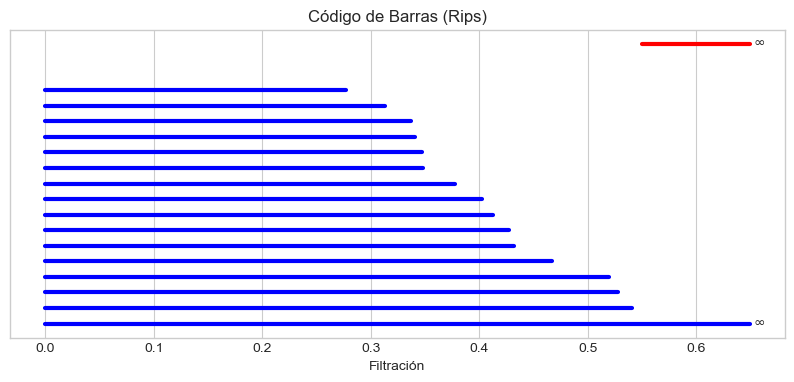

  > Alfa...


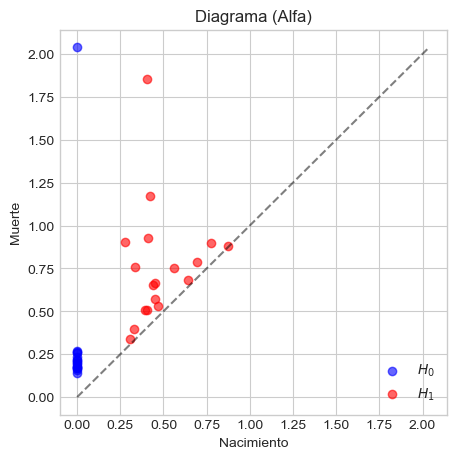


=== 3. VISUALIZACIÓN INCREMENTAL ===

--- Visualización Algoritmo Incremental ---


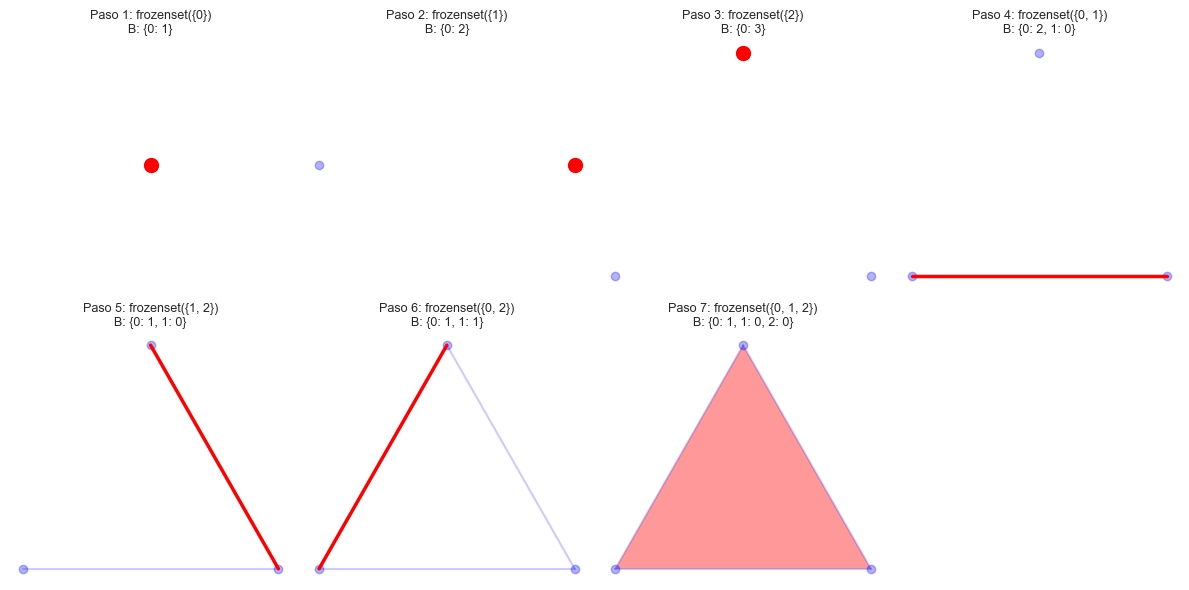

In [14]:
# ==============================================================================
# EJECUCIÓN Y VALIDACIÓN
# ==============================================================================

print("=== 1. NÚMEROS DE BETTI DE SUPERFICIES ===")
surfaces = {
    "Tetraedro": get_tetrahedron(),
    "Toro (7 vért.)": get_torus_minimal(),
    "Botella Klein": get_klein_bottle(),
    "Plano Proyectivo": get_projective_plane(),
    "Sombrero Asno": get_dunce_hat(),
    "Transparencia 4": get_transparency_4_complex()
}

for name, data in surfaces.items():
    sc = SimplicialComplex()
    sc.insert(data)
    print(f"  > {name:<20} | Betti: {sc.betti_numbers()}")

print("\n=== 2. PERSISTENCIA: NUBE DE PUNTOS ===")
np.random.seed(42)
t = np.linspace(0, 2 * np.pi, 16, endpoint=False)
points = np.column_stack([np.cos(t), np.sin(t)]) + np.random.normal(0, 0.08, (16, 2))

print("  > Rips...")
sc_rips = vietoris_rips_filtration(points, 1.5, 2)
diag_rips = compute_persistence_matrix(sc_rips)
plot_barcode(diag_rips, "Código de Barras (Rips)")

print("  > Alfa...")
sc_alpha = alpha_complex_filtration(points)
diag_alpha = compute_persistence_matrix(sc_alpha)
plot_persistence_diagram(diag_alpha, "Diagrama (Alfa)")

print("\n=== 3. VISUALIZACIÓN INCREMENTAL ===")
tri_points = np.array([[0.1, 0.1], [0.9, 0.1], [0.5, 0.8]])
sc_demo = SimplicialComplex()
sc_demo.insert([
    ((0,), 1), ((1,), 2), ((2,), 3),
    ((0,1), 4), ((1,2), 5), ((0,2), 6),
    ((0,1,2), 7)
])
run_visual_incremental(sc_demo, tri_points)


In [15]:
# ==============================================================================
# BLOQUE 6: VISUALIZACIÓN GEOMÉTRICA (VORONOI Y ALFA COMPLEJOS) - CORREGIDO ZOOM
# ==============================================================================

def plot_voronoi_diagram(points, title="Diagrama de Voronoi", show_delaunay=False):
    """
    Dibuja el Diagrama de Voronoi de una nube de puntos.
    Se centra automáticamente en la zona de los puntos para evitar el "zoom lejano"
    causado por las regiones infinitas.
    """
    # Calculamos la teselación de Voronoi
    vor = Voronoi(points)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Dibujamos las fronteras de las celdas de Voronoi en azul
    voronoi_plot_2d(
        vor, ax=ax, show_vertices=False, line_colors='blue', 
        line_width=2, line_alpha=1.0, point_size=2
    )
    
    # Dibujamos los puntos generadores en negro
    ax.plot(points[:, 0], points[:, 1], 'ko', markersize=6, zorder=5, label='Puntos')
    
    # Dibujamos el dual: Triangulación de Delaunay
    if show_delaunay:
        tri = Delaunay(points)
        ax.triplot(points[:, 0], points[:, 1], tri.simplices, 'k--', alpha=0.15, label='Delaunay')
        ax.legend()
    
    ax.set_title(title)
    
    # 1. Calculamos los límites exactos de la nube de puntos
    x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
    y_min, y_max = np.min(points[:, 1]), np.max(points[:, 1])
    
    # 2. Calculamos el ancho y alto total de la nube
    x_range = x_max - x_min
    y_range = y_max - y_min
    
    # 3. Añadimos un margen del 15% a cada lado para que no quede pegado al borde
    # Si los puntos están alineados (rango 0), ponemos un margen mínimo por defecto
    x_margin = x_range * 0.15 if x_range > 0 else 0.5
    y_margin = y_range * 0.15 if y_range > 0 else 0.5
    
    # 4. Forzamos los límites de la gráfica a esta caja calculada
    ax.set_xlim(x_min - x_margin, x_max + x_margin)
    ax.set_ylim(y_min - y_margin, y_max + y_margin)
    
    # Mantenemos la proporción 1:1
    ax.set_aspect('equal', adjustable='box')
    plt.show()

def plot_alpha_complex_at_alpha(points, alpha, title=None):
    """
    Visualiza el Alfa Complejo para un radio específico (alpha).
    Filtra los símplices de Delaunay según su circunradio.
    """
    tri = Delaunay(points)
    
    # Función auxiliar local para calcular el radio de nacimiento
    def get_radius(simp_indices):
        pts = points[list(simp_indices)]
        if len(pts) == 2:
            return np.linalg.norm(pts[0] - pts[1]) / 2.0
        elif len(pts) == 3:
            a, b, c = pts[0], pts[1], pts[2]
            la, lb, lc = np.linalg.norm(b - c), np.linalg.norm(a - c), np.linalg.norm(a - b)
            p = (la + lb + lc) / 2
            area_term = p * (p - la) * (p - lb) * (p - lc)
            area = np.sqrt(area_term) if area_term > 0 else 0
            return (la * lb * lc) / (4 * area) if area > 0 else float('inf')
        return 0.0

    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Dibujamos vértices
    ax.plot(points[:, 0], points[:, 1], 'ko', markersize=5, zorder=5)
    
    # Filtramos y dibujamos triángulos y aristas
    for simplex in tri.simplices:
        if get_radius(simplex) <= alpha:
            pts = points[list(simplex)]
            ax.fill(pts[:, 0], pts[:, 1], 'limegreen', alpha=0.3, edgecolor=None, zorder=2)
            
        for i in range(3):
            edge_idx = [simplex[i], simplex[(i + 1) % 3]]
            if get_radius(edge_idx) <= alpha:
                pts = points[edge_idx]
                ax.plot(pts[:, 0], pts[:, 1], 'k-', alpha=0.8, linewidth=1.5, zorder=3)
    
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f"Alfa Complejo (Radio $\\alpha$ = {alpha})")
        
    ax.set_aspect('equal')
    plt.show()

print("6. Funciones de Visualización Geométrica (Voronoi/Alfa) cargadas y corregidas.")

6. Funciones de Visualización Geométrica (Voronoi/Alfa) cargadas y corregidas.


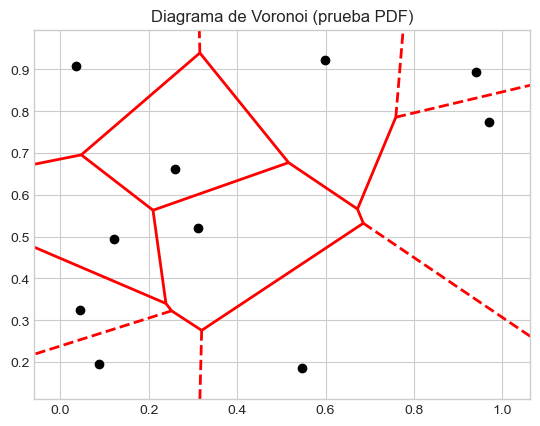

Símplices maximales de Delaunay (Del.simplices):
[[3 4 5]
 [4 3 8]
 [6 7 5]
 [7 3 5]
 [3 9 8]
 [0 9 3]
 [9 0 1]
 [2 7 1]
 [7 2 3]
 [0 2 1]
 [2 0 3]]


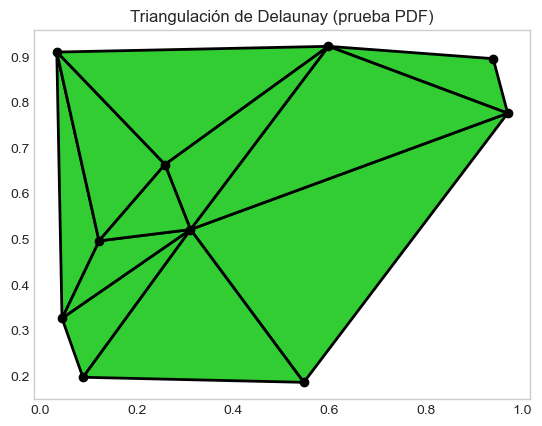

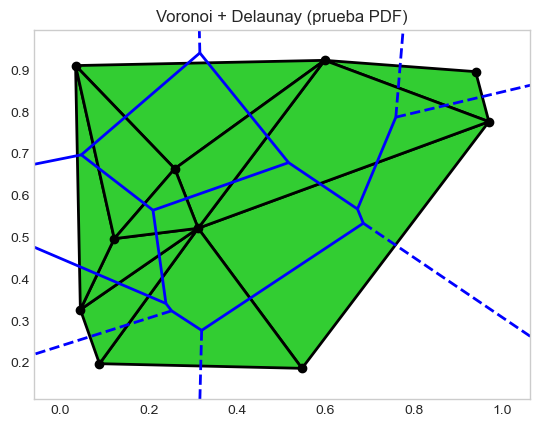

In [16]:
# ============================================================================
# PRUEBAS DEL PDF "Voronoi y Delaunay"
# ============================================================================

import matplotlib.colors
import matplotlib as mpl

# 1) Generar aleatoriamente 10 puntos en el plano
points = np.random.rand(10, 2)

# 2) Calcular diagrama de Voronoi y representarlo
vor = Voronoi(points)

fig = voronoi_plot_2d(
    vor,
    show_vertices=False,
    line_width=2,
    line_colors='red'
)
plt.plot(points[:, 0], points[:, 1], 'ko')
plt.title("Diagrama de Voronoi (prueba PDF)")
plt.show()

# 3) Calcular triangulación de Delaunay
Del = Delaunay(points)

print("Símplices maximales de Delaunay (Del.simplices):")
print(Del.simplices)

# 4) Representar gráficamente la triangulación de Delaunay
c = np.ones(len(points))
cmap = matplotlib.colors.ListedColormap(["limegreen"])

plt.tripcolor(
    points[:, 0], points[:, 1],
    Del.simplices,
    c,
    edgecolor="k",
    lw=2,
    cmap=cmap
)
plt.plot(points[:, 0], points[:, 1], 'ko')
plt.title("Triangulación de Delaunay (prueba PDF)")
plt.show()

# 5) Representar Delaunay sobre Voronoi
fig = voronoi_plot_2d(
    vor,
    show_vertices=False,
    line_width=2,
    line_colors='blue'
)

c = np.ones(len(points))
cmap = matplotlib.colors.ListedColormap(["limegreen"])

plt.tripcolor(
    points[:, 0], points[:, 1],
    Del.simplices,
    c,
    edgecolor="k",
    lw=2,
    cmap=cmap
)
plt.plot(points[:, 0], points[:, 1], 'ko')
plt.title("Voronoi + Delaunay (prueba PDF)")
plt.show()



In [17]:
# ==============================================================================
# REPLICACIÓN DE EJEMPLOS DEL PDF "EJEMPLOS HOMOLOGÍA"
# ==============================================================================

def print_example_results(name, sc):
    print(f"\n--- {name} ---")
    print(f"Borde dim 1: {sc.boundary_matrix(1)}")
    print(f"Borde dim 2: {sc.boundary_matrix(2)}")
    print(f"Borde dim 3: {sc.boundary_matrix(3)}")
    print(f"Dimensión del complejo: {sc.dimension}")
    print(f"Números de Betti: {sc.betti_numbers()}")
    print(f"Car. Euler: {sc.euler_characteristic}")

# ---------------------------------------------------------
# Ejemplo 1: 3-Símplice sólido (Tetraedro relleno)
# ---------------------------------------------------------
sc1 = SimplicialComplex([(0, 1, 2, 3)])
print_example_results("Ejemplo 1: 3-Símplice (Sólido)", sc1)

# ---------------------------------------------------------
# Ejemplo 2: Borde del tetraedro (Esfera S2 hueca)
# ---------------------------------------------------------
# Tomamos todas las caras de dimensión 2 del ejemplo anterior
sc2 = SimplicialComplex(sc1.n_faces(2))
print_example_results("Ejemplo 2: Borde del Tetraedro (S2)", sc2)

# ---------------------------------------------------------
# Ejemplo 3: Complejo mixto
# Símplices maximales: (0,1), (1,2,3,4), (4,5), (5,6), (4,6), (6,7,8), (8,9)
# Nota: (1,2,3,4) es un 3-símplice.
# ---------------------------------------------------------
sc3 = SimplicialComplex([
    (0,1), 
    (1,2,3,4), 
    (4,5), (5,6), (4,6), 
    (6,7,8), 
    (8,9)
    ])
print_example_results("Ejemplo 3: Complejo Mixto", sc3)

# ---------------------------------------------------------
# Ejemplo 4: 1-Esqueleto del Ejemplo 3
# Solo las aristas del complejo anterior
# ---------------------------------------------------------
sc4 = SimplicialComplex(sc3.n_faces(1))
print_example_results("Ejemplo 4: 1-Esqueleto del Ej. 3", sc4)

# ---------------------------------------------------------
# Ejemplo 5: Triángulo relleno + aristas
# Símplices maximales: (0,1,2), (2,3), (3,4)
# ---------------------------------------------------------
sc5 = SimplicialComplex([(0,1,2), (2,3), (3,4)])
print_example_results("Ejemplo 5", sc5)

# ---------------------------------------------------------
# Ejemplo 6: Triangulación del anillo cerrado (Annulus)
# ---------------------------------------------------------
sc6 = SimplicialComplex([
    (1,2,4), (1,3,6), (1,4,6), 
    (2,3,5), (2,4,5), (3,5,6)
])
print_example_results("Ejemplo 6: Anillo Cerrado", sc6)

# ---------------------------------------------------------
# Ejemplo 7: 1-Esqueleto del anillo
# ---------------------------------------------------------
sc7 = SimplicialComplex(sc6.n_faces(1))
print_example_results("Ejemplo 7: 1-Esqueleto del Anillo", sc7)

# ---------------------------------------------------------
# Ejemplo 8: El Toro (Triangulación)
# ---------------------------------------------------------
sc8 = SimplicialComplex([
    (1,2,4), (2,4,5), (2,3,5), (3,5,6), (1,3,6), (1,4,6),
    (4,5,7), (5,7,8), (5,6,8), (6,8,9), (4,6,9), (4,7,9),
    (1,7,8), (1,2,8), (2,8,9), (2,3,9), (3,7,9), (1,3,7)
])
print_example_results("Ejemplo 8: El Toro", sc8)

# ---------------------------------------------------------
# Ejemplo 9: Plano Proyectivo Real (RP2)
# Nota: En homología Z2, los Betti numbers deberían ser {0:1, 1:1, 2:1}
# ---------------------------------------------------------
sc9 = SimplicialComplex([
    (1,2,6), (2,3,4), (1,3,4), (1,2,5), (2,3,5), 
    (1,3,6), (2,4,6), (1,4,5), (3,5,6), (4,5,6)
])
print_example_results("Ejemplo 9: Plano Proyectivo", sc9)

# ---------------------------------------------------------
# Ejemplo 10: Sistema disconexo
# Símplices: (0,), (1,), (2,3), (4,5), (5,6), (4,6), (6,7,8,9)
# ---------------------------------------------------------
sc10 = SimplicialComplex([
    (0,), (1,), 
    (2,3), 
    (4,5), (5,6), (4,6), 
    (6,7,8,9)
])
print_example_results("Ejemplo 10: Sistema Disconexo", sc10)


--- Ejemplo 1: 3-Símplice (Sólido) ---
Borde dim 1: [[1 1 1 0 0 0]
 [1 0 0 1 1 0]
 [0 1 0 1 0 1]
 [0 0 1 0 1 1]]
Borde dim 2: [[1 1 0 0]
 [1 0 1 0]
 [0 1 1 0]
 [1 0 0 1]
 [0 1 0 1]
 [0 0 1 1]]
Borde dim 3: [[1]
 [1]
 [1]
 [1]]
Dimensión del complejo: 3
Números de Betti: {0: 1, 1: 0, 2: 0, 3: 0}
Car. Euler: 1

--- Ejemplo 2: Borde del Tetraedro (S2) ---
Borde dim 1: [[1 1 1 0 0 0]
 [1 0 0 1 1 0]
 [0 1 0 1 0 1]
 [0 0 1 0 1 1]]
Borde dim 2: [[1 1 0 0]
 [1 0 1 0]
 [0 1 1 0]
 [1 0 0 1]
 [0 1 0 1]
 [0 0 1 1]]
Borde dim 3: []
Dimensión del complejo: 2
Números de Betti: {0: 1, 1: 0, 2: 1}
Car. Euler: 2

--- Ejemplo 3: Complejo Mixto ---
Borde dim 1: [[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1]]
Borde dim 2: [[0 0 0 0 0]
 [1 1 0 0 0]


PROCESANDO: Ejemplo 1: Nube Básica

---> 1. Homología Persistente de Ejemplo 1: Nube Básica


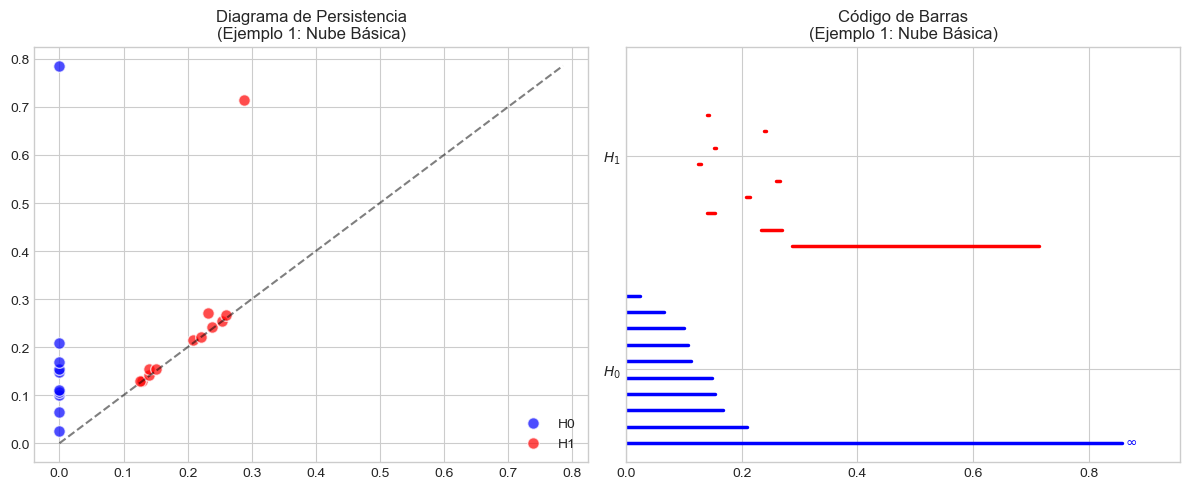


---> 2. Geometría: Voronoi


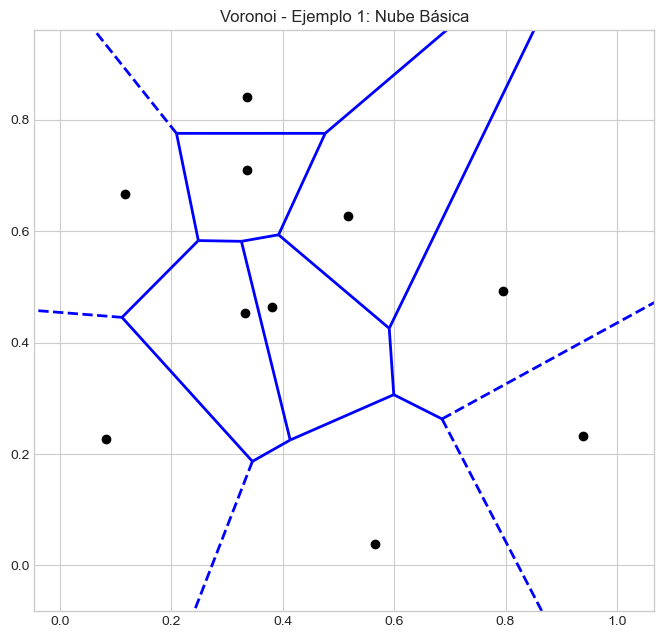


---> 3. Alfa Complejo para alpha = 0.26


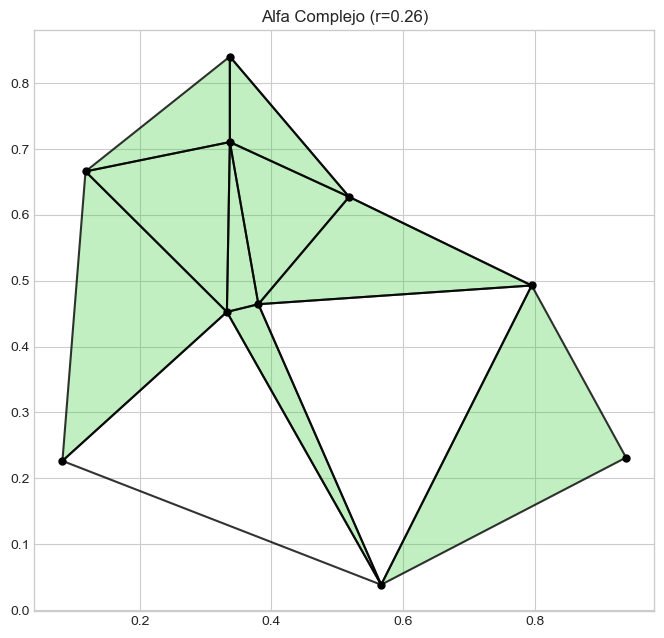


PROCESANDO: Ejemplo 2: Nube Dispersa

---> 1. Homología Persistente de Ejemplo 2: Nube Dispersa


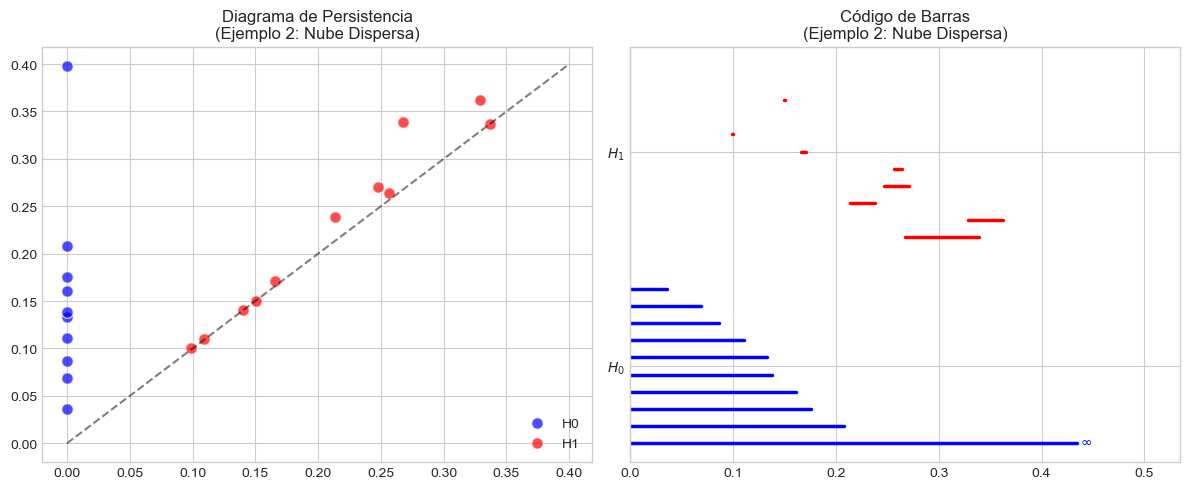


---> 2. Geometría: Voronoi


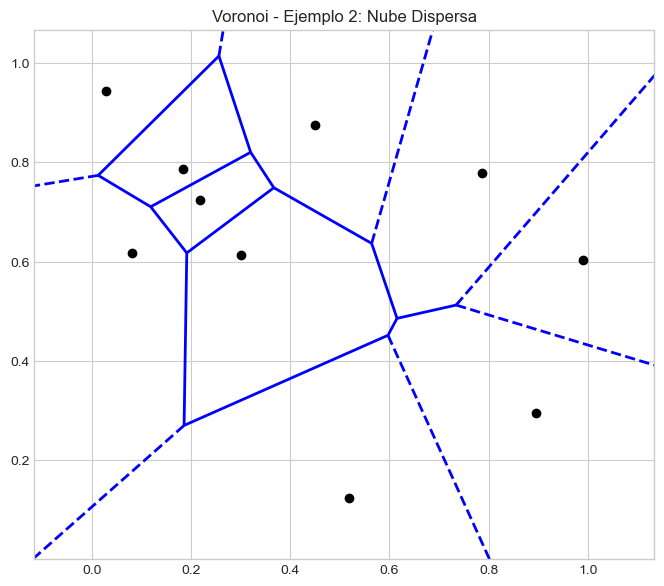


---> 3. Alfa Complejo Automático (Ciclo detectado en r=0.303)


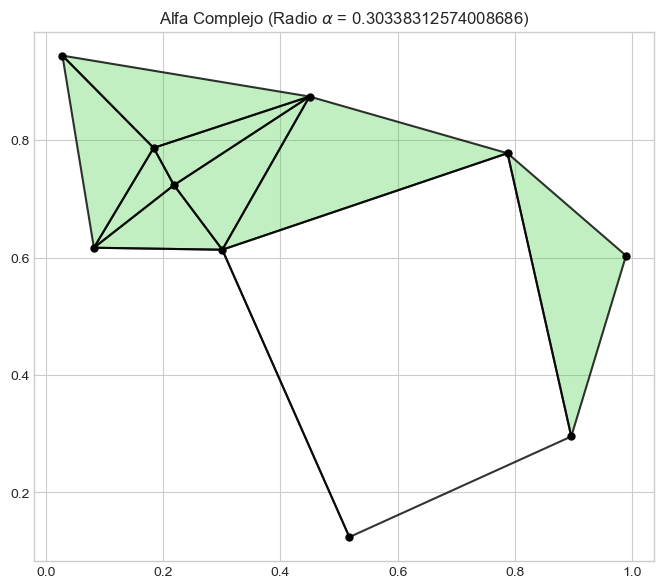


PROCESANDO: Ejemplo 3: Nube Densa

---> 1. Homología Persistente de Ejemplo 3: Nube Densa


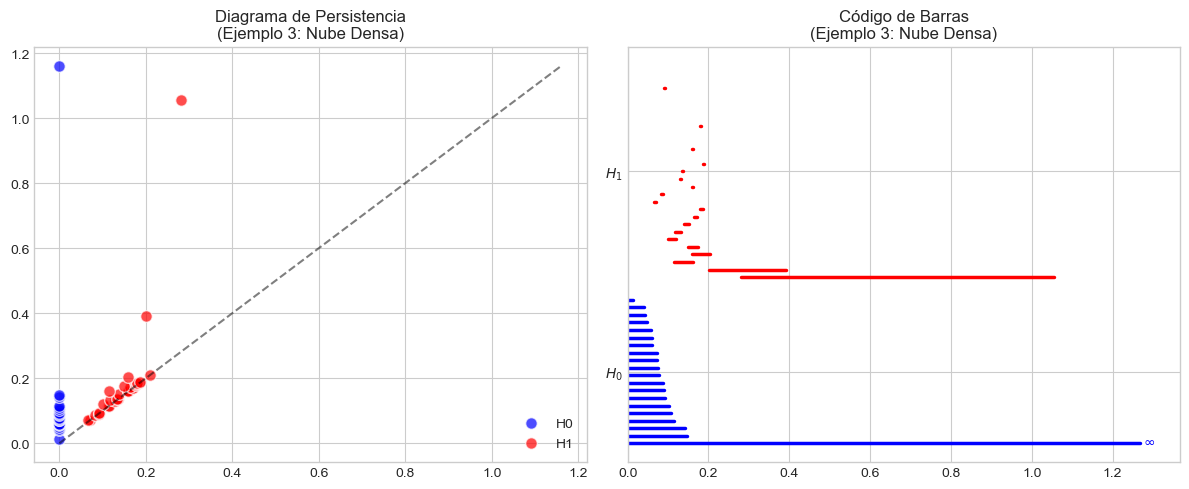


---> 2. Geometría: Voronoi


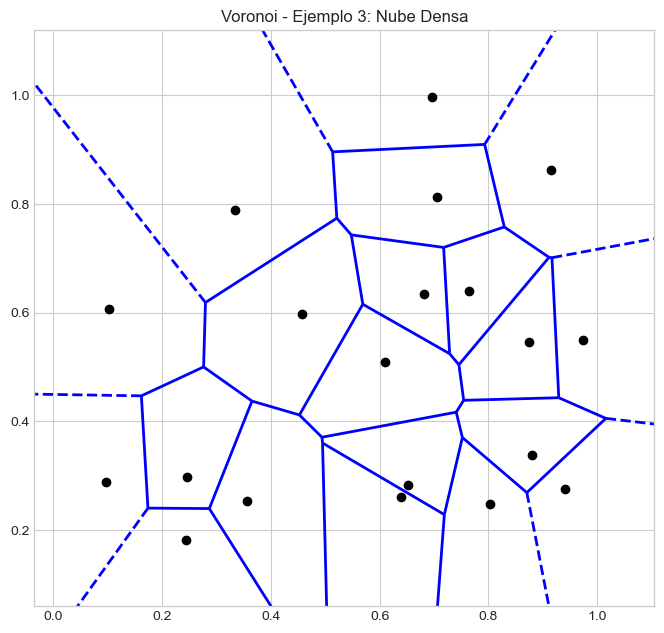


---> 3. Alfa Complejo para alpha = 0.22


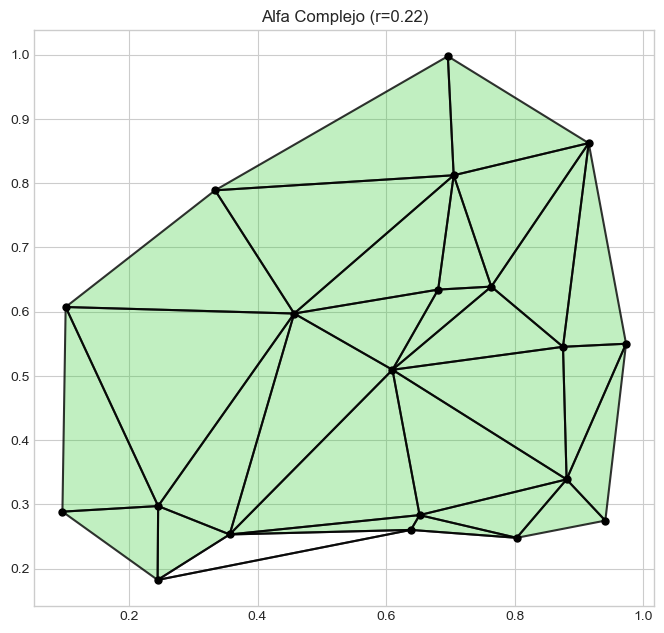


PROCESANDO: Ejemplo 4: Círculo Ruidoso (Persistencia H1)

---> 1. Homología Persistente de Ejemplo 4: Círculo Ruidoso (Persistencia H1)


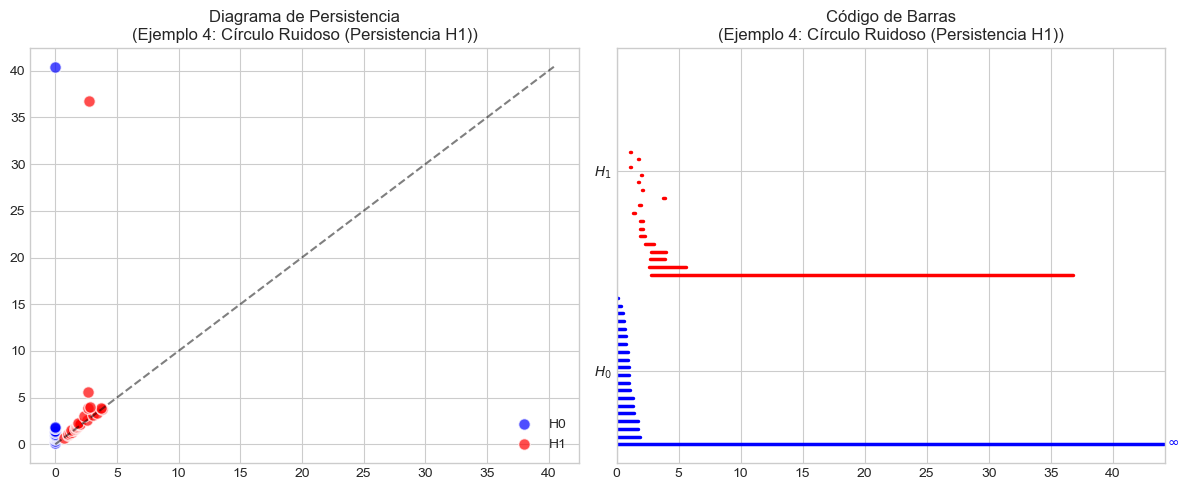


---> 2. Geometría: Voronoi


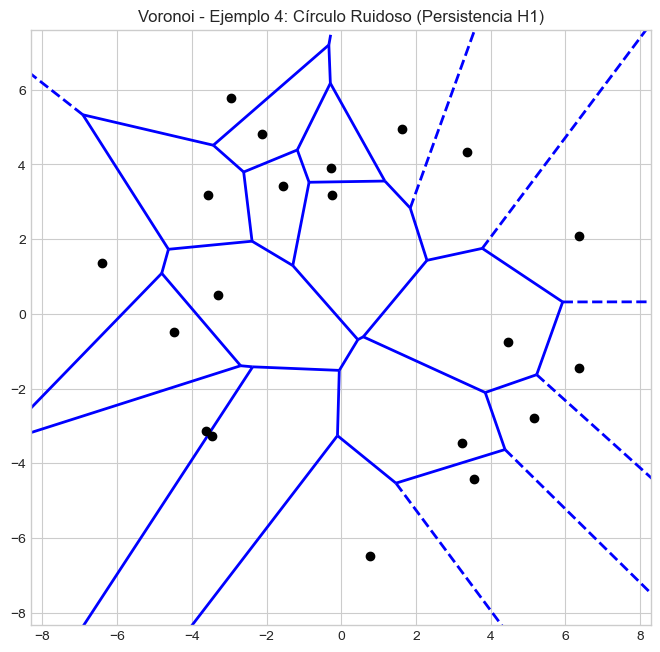


---> 3. Alfa Complejo Automático (Ciclo detectado en r=19.759)


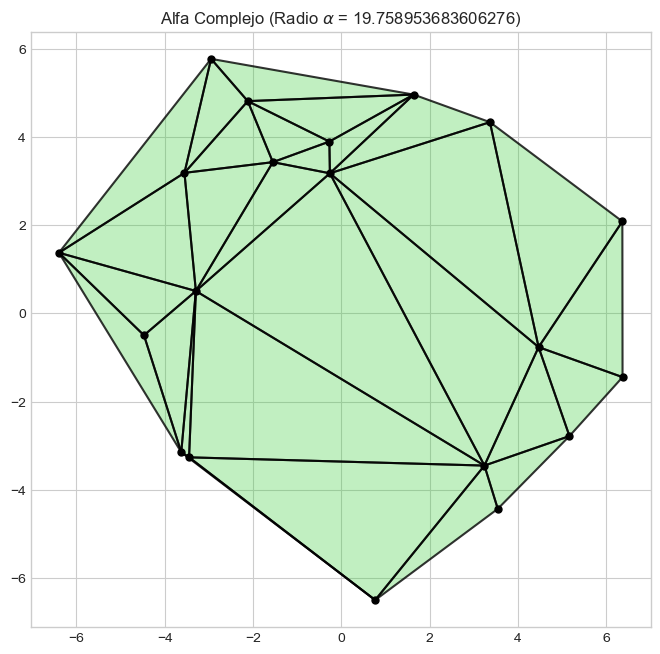

In [19]:
# ==============================================================================
# PARTE 2: REPLICACIÓN DE EJEMPLOS DEL PDF "EJEMPLOS ALPHA Y VR"
# ==============================================================================

def analyze_and_visualize_alpha(points, title="Análisis de Nube de Puntos", specific_alpha=None):
    """
    Realiza el análisis completo: Persistencia + Voronoi + Alfa.
    """
    print(f"\n{'='*60}")
    print(f"PROCESANDO: {title}")
    print(f"{'='*60}")
    
    # --- 1. CÁLCULO DE PERSISTENCIA ---
    sc_alpha = alpha_complex_filtration(points)
    diag = compute_persistence_matrix(sc_alpha)
    
    print(f"\n---> 1. Homología Persistente de {title}")
    # (Aquí va el código de plotear persistencia/barras que ya tenías bien... 
    #  ... lo resumo para no copiar todo el tocho, MANTÉN TU CÓDIGO DE PLOTS AQUÍ)
    # [PEGAR CÓDIGO DE SUBPLOTS DE PERSISTENCIA AQUÍ]
    plt.figure(figsize=(12, 5))
    ax1 = plt.subplot(1, 2, 1)
    # ... (Tu código de scatter plot) ...
    valid_dims = [d for d in diag.keys() if d < 2]
    all_vals = [d for dim in valid_dims for b, d in diag[dim] if d != float('inf')]
    max_val = max(all_vals) if all_vals else 1.0
    inf_limit = max_val * 1.1
    ax1.plot([0, inf_limit], [0, inf_limit], 'k--', alpha=0.5)
    colors = {0: 'blue', 1: 'red', 2: 'green'}
    for dim in sorted(valid_dims):
        pairs = diag[dim]
        births = [p[0] for p in pairs]
        deaths = [p[1] if p[1] != float('inf') else inf_limit for p in pairs]
        ax1.scatter(births, deaths, color=colors.get(dim, 'k'), label=f'H{dim}', alpha=0.7, edgecolors='white', s=70)
    ax1.set_title(f"Diagrama de Persistencia\n({title})")
    ax1.legend()

    ax2 = plt.subplot(1, 2, 2)
    # ... (Tu código de barcode) ...
    y = 0
    all_vals_bar = [d for dim in valid_dims for b, d in diag[dim] if d != float('inf')]
    max_val_bar = max(all_vals_bar) if all_vals_bar else 1.0
    inf_limit_bar = max_val_bar * 1.2
    ytick_pos, ytick_labels = [], []
    for dim in sorted(valid_dims):
        bars = sorted(diag[dim], key=lambda x: (x[1] if x[1] != float('inf') else 999) - x[0], reverse=True)
        start_y = y
        for b, d in bars:
            end = d if d != float('inf') else inf_limit_bar
            ax2.plot([b, end], [y, y], color=colors.get(dim, 'k'), lw=2.5)
            if d == float('inf'):
                ax2.text(end, y, r' $\infty$', va='center', color=colors.get(dim, 'k'))
            y += 1
        ytick_pos.append(start_y + (y - start_y) / 2 - 0.5)
        ytick_labels.append(f"$H_{{{dim}}}$")
        y += 2
    ax2.set_yticks(ytick_pos)
    ax2.set_yticklabels(ytick_labels)
    ax2.set_title(f"Código de Barras\n({title})")
    ax2.set_xlim(0, inf_limit_bar + 0.1)
    plt.tight_layout()
    plt.show()

    # --- 2. DIAGRAMA DE VORONOI ---
    print(f"\n---> 2. Geometría: Voronoi")
    # AQUÍ ESTÁ EL CAMBIO: Llamamos a la función en lugar de reescribirla
    plot_voronoi_diagram(points, title=f"Voronoi - {title}", show_delaunay=False)

    # --- 3. ALFA COMPLEJO ESPECÍFICO ---
    if specific_alpha is not None:
        print(f"\n---> 3. Alfa Complejo para alpha = {specific_alpha}")
        plot_alpha_complex_at_alpha(points, specific_alpha, title=f"Alfa Complejo (r={specific_alpha})")
    else:
        h1_intervals = [i for i in diag.get(1, []) if i[1] != float('inf')]
        if h1_intervals:
            longest = max(h1_intervals, key=lambda x: x[1]-x[0])
            mid_alpha = (longest[0] + longest[1]) / 2
            print(f"\n---> 3. Alfa Complejo Automático (Ciclo detectado en r={mid_alpha:.3f})")
            plot_alpha_complex_at_alpha(points, mid_alpha)
        else:
            print("\n---> 3. Alfa Complejo (Delaunay completo)")
            plot_alpha_complex_at_alpha(points, 100.0, title="Triangulación de Delaunay Completa")


# ==============================================================================
# DATOS DE LOS EJEMPLOS (COORDENADAS DEL PDF)
# ==============================================================================

# Ejemplo 1: 10 Puntos aleatorios
points1=np.array([(0.38021546727456423, 0.46419202339598786),
                 (0.7951628297672293, 0.49263630135869474),
                 (0.566623772375203, 0.038325621649018426),
                 (0.3369306814864865, 0.7103735061134965),
                 (0.08272837815822842, 0.2263273314352896), 
                 (0.5180166301873989, 0.6271769943824689),
                 (0.33691411899985035, 0.8402045183219995),
                 (0.33244488399729255, 0.4524636520475205), 
                 (0.11778991601260325, 0.6657734204021165),
                 (0.9384303415747769, 0.2313873874340855)])

# Ejemplo 2: Nube dispersa
points2=np.array([[0.8957641450573793, 0.2950833519989374],
                  [0.028621391963087994, 0.9440875759025237],
                  [0.517621505875702, 0.1236620161847416],
                  [0.7871047164191424, 0.7777474116014623],
                  [0.21869796914805273, 0.7233589914276723],
                  [0.9891035292480995, 0.6032186214942837],
                  [0.30113764052453484, 0.613321425324272],
                  [0.18407448222466916, 0.7868606964403773],
                  [0.4496777667376678, 0.874366215574117],
                  [0.08225571534539433, 0.616710205071694]])

# Ejemplo 3: Nube densa (~20 puntos)
points3=np.array([(0.8753299639906736, 0.5452963206013219),
(0.915335120559448, 0.8622822047328554),
(0.9411759819184322, 0.2748278885761678),
(0.7052034033196758, 0.8122389578499669),
(0.9734431558329487, 0.5500672178217452),
(0.101349658961157, 0.6072126518098413),
(0.6099428935549683, 0.5095146187792166),
(0.6810379648990679, 0.6343196355745316),
(0.763747595111296, 0.6389758508715849),
(0.6521290891236327, 0.28340359060768416),
(0.4569706839687516, 0.5970966728571825),
(0.3339042514617916, 0.7888181435443109),
(0.24447615661103717, 0.18247811626397858),
(0.6961254832425103, 0.9974914431850389),
(0.2452860638322797, 0.2974794924024807),
(0.09631846692736679, 0.2887656085651358),
(0.638575556222527, 0.26034722595932536),
(0.803241921795395, 0.24803894619975986),
(0.8809182300057703, 0.3389661339754195),
(0.3565859265456749, 0.25327819736066515)])

# Ejemplo 4: Círculo con ruido
circle = np.array([[ 0.7649936 , -6.49105706],
[-0.26047978, 3.17414802],
[ 5.16486466, -2.77709227],
[ 6.3630621 , 2.08442442],
[ 1.63681198, 4.95671697],
[-4.47103343, -0.4944843 ],
[-2.12035066, 4.80887876],
[-3.44986384, -3.25828704],
[-3.55428879, 3.18415674],
[-0.27202076, 3.89295058],
[-2.9512385 , 5.76602403],
[ 6.36747098, -1.44195299],
[ 3.36400365, 4.33230353],
[ 3.23972602, -3.44494391],
[-3.29551494, 0.50827386],
[-1.55188576, 3.42645393],
[-3.62672644, -3.14264111],
[ 3.54177077, -4.42486894],
[-6.39734363, 1.37489294],
[ 4.46578318, -0.76225718]])

# Ejemplo 1 (Con radio específico 0.26 como en el PDF para ver el ciclo)
analyze_and_visualize_alpha(points1, "Ejemplo 1: Nube Básica", specific_alpha=0.26)

# Ejemplo 2 (Sin radio específico, mostrará Delaunay completo o ciclo significativo)
analyze_and_visualize_alpha(points2, "Ejemplo 2: Nube Dispersa")

# Ejemplo 3 (Con radio 0.22 aprox para ver estructuras)
analyze_and_visualize_alpha(points3, "Ejemplo 3: Nube Densa", specific_alpha=0.22)

# Ejemplo 4 (Círculo Ruidoso - Buscamos detectar el agujero central)
analyze_and_visualize_alpha(circle, "Ejemplo 4: Círculo Ruidoso (Persistencia H1)")